# Predicting Malignant Breast Cancer with XGBoost

Breast cancer is a rising condition in much of the developed world that puts a patient at risk of serious health complications and may be potentially fatal. The widespread burden of this disease affects not just patients but families, communities, workplaces and the health system. Early screening of breast cancer can be an effective way to treat the condition such that chemotherapy and surgical removal can be invoked before the cancer has a chance to spread. Making a diagnosis based on biopsy and mammogram results require the expertise of a medical professional observing characteristics of the sample and its source. The imperfection in diagnosis and necessity to make accurate judgements suggests the potential of a machine learning algorithm that can save time and lives.


In [227]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import xgboost as xgb

   ###  Attribute                     Domain
   
   The dataset I used were compiled from University of Wisconsin Hospitals, Madison collected January 8th, 1991. These samples were collected over a period of two years from January 1989 to November 1991 from patients seen in clinic at the hospital. We can expect that a lot of patients seen were likely to be currently or previously experiencing some kind of health condition with many potential breast cancer patients. The attributes of each sample were measurements of the sample this included:

   
   
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
   10. Mitoses                       1 - 10
   11. Class                        2 for benign, 4 for malignant

In [176]:
data = pd.read_csv("breast-cancer-wisconsin.data", header = None)
data.columns = ['sample_code','clump_thickness','uniformity_of_cell_size','uniformity_of_cell_shape','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','malignant']
data['malignant'] = data['malignant'].map({2: 0, 4: 1})
data = data.replace('?', np.nan)

In [175]:
data

,sample_code,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,0
695,841769,2,1,1,1,2,1,1,1,1,0
696,888820,5,10,10,3,7,3,8,10,2,1
697,897471,4,8,6,4,3,4,10,6,1,1


To prepare the data for a machine learning algorithm it was necessary to first extract the relevant features from the dataset leaving out irrelevant features which would add noise to the model (sample code number). Then I rekeyed in the classification column which was originally keyed in as 2 for benign and 4 for malignant. I made this into a single dummy variable called “malignant” which took on 1 if the sample was of a malignant tumour and 0 if it was of a benign tumour. The model I wanted to use required that I split the data into training and test datasets. Of 699 observations I decided that 140 observations were sufficient to ask as test dataset and the remaining 559 would make up the training dataset making the train to test ratio 5:1. In order to observe the consistency of the modelling I randomly generated 100 permutations of this split and ran the model on each one.


In [177]:
data.malignant.value_counts()

0    458
1    241
Name: malignant, dtype: int64

In [178]:
data_matrix = data.to_numpy()
data_matrix = data_matrix.astype(float, casting='unsafe')
#generating a random permutation of features
permutation = np.random.permutation(len(data))
data_matrix = data_matrix[permutation]
#building training and test datasets (I take out sample_code because it is an irrelevant feature)
test_data = data_matrix[:140,1:]
train_data = data_matrix[140:,1:]
print("The length of the test dataset is ", len(test_data), " and for the training dataset is ", len(train_data))

#splitting into features and labels
test_x = test_data[:,:9]
test_y = test_data[:,9]
train_x = train_data[:,:9]
train_y = train_data[:,9]

The length of the test dataset is  140  and for the training dataset is  559


The method I used was gradient boosted decision tree algorithms using the XGBoost package. In particular I made the objective learning task to ‘binary:hinge’ meaning it would try to predict the binary outcome for each observation. The evaluation metric I used was the ‘error’ metric, meaning that the number of wrong classifications were used to train the model and similarly to evaluate it on the test set. I randomly split the data 100 times and ran this model on each iteration of the dataset to observe if the model could consistently accurately predict the presence of a malignant tumour. I set an early stop criteria to be 10, meaning the model would stop being trained if it’s success score on the test set did not improve after 10 rounds.


In [179]:
#parameter list function
def xgboost_plst():
    param = {}
    param['max_depth']= 3   # depth of tree
    param['eta'] = 0.3      # shrinkage parameter
    #param['silent'] = 1     # not silent
    param['objective'] = 'binary:hinge' #necessary for this task
    param['nthread'] = 3 # Number of threads used
    param['eval_metric'] = 'error'

    plst = param.items()
    return plst

In [188]:
bootstrap = 100
success = []
gain = []
weight = []
cover = []
total_gain = []
total_cover = []
for n in range(bootstrap):    
    permutation = np.random.permutation(len(data))
    data_matrix = data_matrix[permutation]
    test_data = data_matrix[:140,1:]
    train_data = data_matrix[140:,1:]
    test_x = test_data[:,:9]
    test_y = test_data[:,9]
    train_x = train_data[:,:9]
    train_y = train_data[:,9]
    #setting out teest and trainig matrices
    dtrain = xgb.DMatrix(data = train_x, label=train_y)
    dtest = xgb.DMatrix(data = test_x, label = test_y)
    # Training boost model
    plst=xgboost_plst()
    evallist = [(dtrain, 'train'),(dtest, 'eval')]
    bst = xgb.train(plst, dtrain, 100, evallist, verbose_eval = False, early_stopping_rounds=10)
    outputs = bst.predict(dtest, output_margin=False)
    success.append(len(test_y[test_y == outputs])/len(test_y))
    gain.append(bst.get_score(importance_type= 'gain'))
    weight.append(bst.get_score(importance_type= 'weight'))
    cover.append(bst.get_score(importance_type= 'cover'))
    total_gain.append(bst.get_score(importance_type= 'total_gain'))
    total_cover.append(bst.get_score(importance_type= 'total_cover'))
    print("XGBoost model number ", n+1 ," correctly predicted malignant cancer in ", len(test_y[test_y == outputs])/len(test_y)*100, "% of cases")

XGBoost model number  1  correctly predicted malignant cancer in  92.85714285714286 % of cases
XGBoost model number  2  correctly predicted malignant cancer in  92.14285714285714 % of cases
XGBoost model number  3  correctly predicted malignant cancer in  95.0 % of cases
XGBoost model number  4  correctly predicted malignant cancer in  95.71428571428572 % of cases
XGBoost model number  5  correctly predicted malignant cancer in  95.0 % of cases
XGBoost model number  6  correctly predicted malignant cancer in  95.0 % of cases
XGBoost model number  7  correctly predicted malignant cancer in  94.28571428571428 % of cases
XGBoost model number  8  correctly predicted malignant cancer in  98.57142857142858 % of cases
XGBoost model number  9  correctly predicted malignant cancer in  95.71428571428572 % of cases
XGBoost model number  10  correctly predicted malignant cancer in  93.57142857142857 % of cases
XGBoost model number  11  correctly predicted malignant cancer in  98.57142857142858 % o

In [197]:
weightdf = pd.DataFrame(weight) 
weightdf.columns = ['clump_thickness','uniformity_of_cell_size','uniformity_of_cell_shape','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses']
gaindf = pd.DataFrame(gain)
gaindf.columns = ['clump_thickness','uniformity_of_cell_size','uniformity_of_cell_shape','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses']
coverdf = pd.DataFrame(cover)
coverdf.columns = ['clump_thickness','uniformity_of_cell_size','uniformity_of_cell_shape','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses']
total_gaindf = pd.DataFrame(total_gain)
total_gaindf.columns = ['clump_thickness','uniformity_of_cell_size','uniformity_of_cell_shape','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses']
total_coverdf = pd.DataFrame(total_cover)
total_coverdf.columns = ['clump_thickness','uniformity_of_cell_size','uniformity_of_cell_shape','marginal_adhesion','single_epithelial_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses']

Text(0, 0.5, 'Number of occurences')

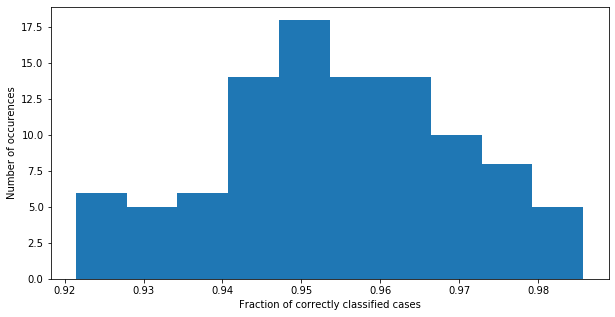

In [208]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
pyplot.hist(success, label='Percentage of correctly classified cases')
plt.xlabel('Fraction of correctly classified cases')
plt.ylabel('Number of occurences')

The XGBoost models consistently classified cases of Malignant tumours with at least 92 percent accuracy with the majority of models generated predicating above 95 percent accuracy. This result demonstrates that XGBoost classification does significantly better than a random classifier in predicting tumours and in fact we can expect it to predict 19/20 cases accurately. The fact that the accuracy is consistently high points suggest a robust and potentially generalizable model.

Text(0.5, 0.98, 'Feature Coverage')

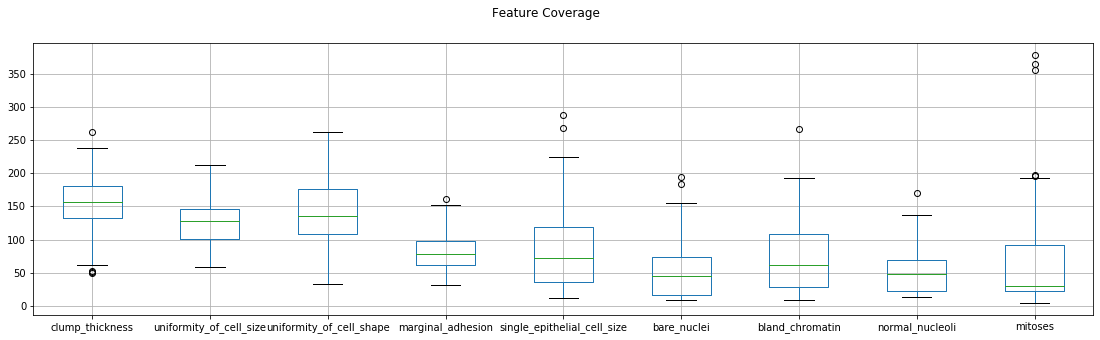

In [224]:
plt.rcParams['figure.figsize'] = [19, 5]
coverdf.boxplot()
plt.suptitle("Feature Coverage")

This boxplot represents the distribution of feature coverage across all 100 models. To interpret the number on this graph it is important to understand that on each of the models trained by their respective random permutation of data results in different amounts of observations being discriminated in the decision trees. The number “coverage” represents the amount of observations that were classified in a leaf a node for each of the trees. We can consider this as to mean that features with higher “coverage” were more relevant to each decision tree. This however does not take into consider the relative weights of each decision tree.

Text(0.5, 0.98, 'Gain in accuracy for each feature')

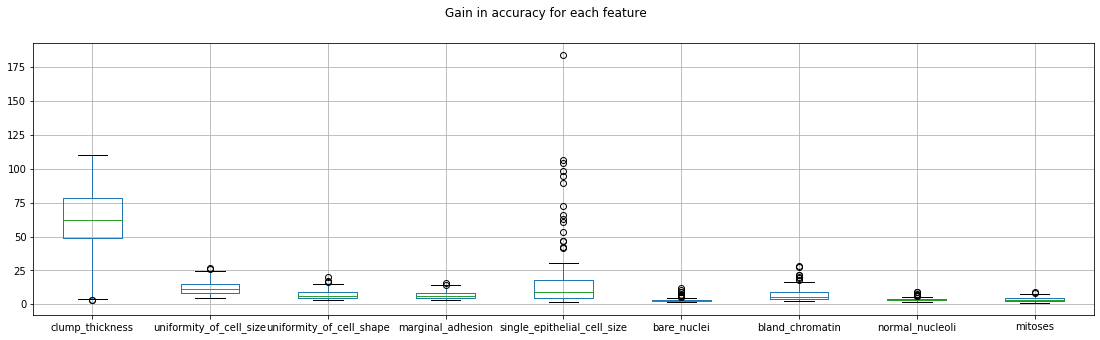

In [222]:
gaindf.boxplot()
plt.suptitle("Gain in accuracy for each feature")

In the previous boxplot we saw that each feature generally received the same amount of coverage in predictions, with clump thickness being the most coverage and mitoses being the least. In this boxplot we see which features received more “weight” in the final model, Clump thickness, Uniformity of cell size and marginal adhesion typically receives the most amount of weight relative to other features. This means that they were the most relevant for generating model predictions

Text(0.5, 0.98, 'Weight for each feature')

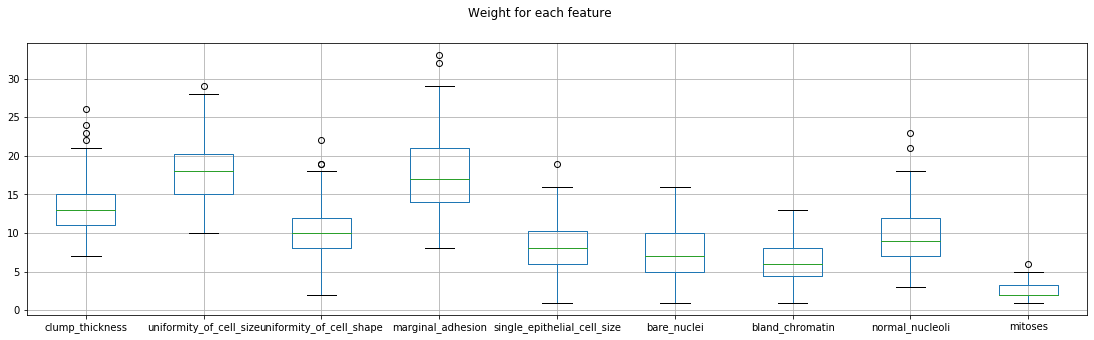

In [223]:
weightdf.boxplot()
plt.suptitle("Weight for each feature")

Finally we can observe the gain in accuracy for each feature to be the increase in the models accuracy for the inclusion of each feature. We see once again that clump thickness is responsible for a significant amount of gain in the accuracy of the machine learning algorithms, additionally single epithelial-cell-size appears to be responsible for increases in accuracy. Based on the graphs it appears that clump thickness appears to be the most relevant feature in classification however its usefulness may also be dependant on the inclusion of these other features.


### Limitations

Ultimately the dataset was a relatively small sample of patients who have breast cancer and therefore it is not easy to say that a machine learning model like the one generated can be generalizable. The dataset also comes from a clinic which regularly sees women who are going through cancer and typically not healthy individuals with no relevant medical history. Therefore the models generated may be useful only in a subset of individuals who are likely to go to seek treatment in the hospital. This means that this machine learning algorithm may not be generalizable to samples from healthy individuals thus resulting in significant numbers of false positives. And finally even a 19/20 accuracy rate means that 1/20 cases are misclassified, given the severity of such an illness it would not be advisable to solely rely on a machine learning model with that accuracy to diagnose patients. 


#### References

1. O.L.Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear 
      programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of 
      pattern separation for medical diagnosis applied to breast cytology", 
      Proceedings of the National Academy of Sciences, U.S.A., Volume 87, 
      December 1990, pp 9193-9196.
3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition 
      via linear programming: Theory and application to medical diagnosis", 
      in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying
      Li, editors, SIAM Publications, Philadelphia 1990, pp 22-30.
4. K. P. Bennett & O. L. Mangasarian: "Robust linear programming 
      discrimination of two linearly inseparable sets", Optimization Methods
      and Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).
5. https://en.wikipedia.org/wiki/Breast_cancer
6. https://xgboost.readthedocs.io/en/latest/index.html

